In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from re import split
from scipy.interpolate import griddata
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from re import split
from matplotlib.animation import ArtistAnimation
from scipy.ndimage import label
from scipy.ndimage.morphology import binary_closing
import matplotlib.ticker as plticker
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
import dask.array as da
from textwrap import wrap

from skimage.filters import gaussian, threshold_otsu
from skimage import measure
from dask_image.ndfilters import uniform_filter as uf
from dask_image.ndmeasure import variance as varian


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']

In [31]:
def lee_filter_new(img, size, tresh=-150):
    if len(img.dims) == 2:
        shape = (size, size)
    else:
        shape = (size, size, 1)

    img = da.where(da.logical_or(da.isnan(img), da.equal(img, -np.inf)), tresh, img)
    img_mean = uf(img, shape)
    img_sqr_mean = uf(da.power(img, 2), shape)
    img_variance = img_sqr_mean - da.power(img_mean, 2)
    overall_variance = varian(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output


def regrid(ds_xr):
 # ds_xr = ds_xr.where(ds_xr.alt3D > 500, drop=True)
    x = ds_xr.range * np.sin(np.deg2rad(ds_xr.azimuth))  # add roll
    y = ds_xr.alt3D * np.cos(np.deg2rad(ds_xr.azimuth))
    z = ds_xr.zhh14.where(ds_xr.alt3D > 500)
    # z = np.where(z > 0, z, 0)
    z = lee_filter_new(z, size=3, tresh=-180)
    z[z == -9999] = 0
    z[z == -180.] = 0
    x_s = x.values.flatten()
    y_s = y.values.flatten()
    z_s = z.compute().flatten()
    idx = x_s.argsort()
    x_s, y_s = np.take_along_axis(x_s, idx, axis=0), np.take_along_axis(y_s, idx, axis=0)
    z_s = np.take_along_axis(z_s, idx, axis=0)


    ### desired gridded data
    ncols = np.abs(x_s.max() - x_s.min()) / 5
    nrows = np.abs(y_s.max() - y_s.min()) / 5
    x_new = np.linspace(x_s.min(), x_s.max(), int(ncols))
    y_new = np.linspace(y_s.min(), y_s.max(), int(nrows))
    xi, yi = np.meshgrid(x_new, y_new)
    
    ## performing the interpolation
    z0 = griddata((x_s, y_s), z_s, (xi, yi), method='linear', fill_value=0.0)
    z0 = np.where(z0 > 0, z0, np.nan)
    z1 = griddata((x_s, y_s), z_s, (xi, yi), method='cubic', fill_value=0.0)
    z1 = np.where(z1 > 0, z1, np.nan)
    z2 = griddata((x_s, y_s), z_s, (xi, yi), method='nearest')
    z2 = np.where(z2 > 0, z2, np.nan)
    z = np.where(z > 0, z, np.nan)

    fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True, sharex=True)
    im = ax[0][0].pcolormesh(x, y, z, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[0][0].set_title('Original')

    im = ax[0][1].pcolormesh(xi, yi, z0, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[0][1].set_title('Linear')

    im1 = ax[1][0].pcolormesh(xi, yi, z1, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[1][0].set_title('Cubic')

    im2 = ax[1][1].pcolormesh(xi, yi, z2, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[1][1].set_title('Nearest')

    cbar1 = plt.colorbar(im, ax=[ax[0][0], ax[0][1]])
    cbar1.set_label("\n".join(wrap(ds_xr.zhh14.notes, 50)) + ' (dBZ)')
    cbar2 = plt.colorbar(im2, ax=[ax[1][0], ax[1][1]])

    cbar2.set_label("\n".join(wrap(ds_xr.zhh14.notes, 50)) + ' (dBZ)')
    title = f"{np.datetime_as_string(ds_xr.time.values, unit='s')}\n"
    fig.suptitle(title, fontsize=16, y=.92)

    ax[0][0].set_ylim(0, 8000)
    ax[1][1].set_ylim(0, 8000)
    ax[1][0].set_ylabel('Height (m)')
    ax[1][0].set_xlabel('Cross track (m)')
    ax[0][0].set_ylabel('Height (m)')
    ax[1][1].set_xlabel('Cross track (m)')
    plt.savefig('interpolation.jpg')
    plt.show()
    print('a')
    return xi, yi, z0


In [32]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

In [33]:
ds_xr = ds_xr.sel(time='2019-09-16 03:12:58').isel(time=0)
# ds_xr = ds_xr.where(ds_xr.alt3d > 500, drop=True)

/tmp/ipykernel_181798/4275307648.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0][0].pcolormesh(x, y, z, cmap='jet', vmax=40, vmin=0, shading='auto')


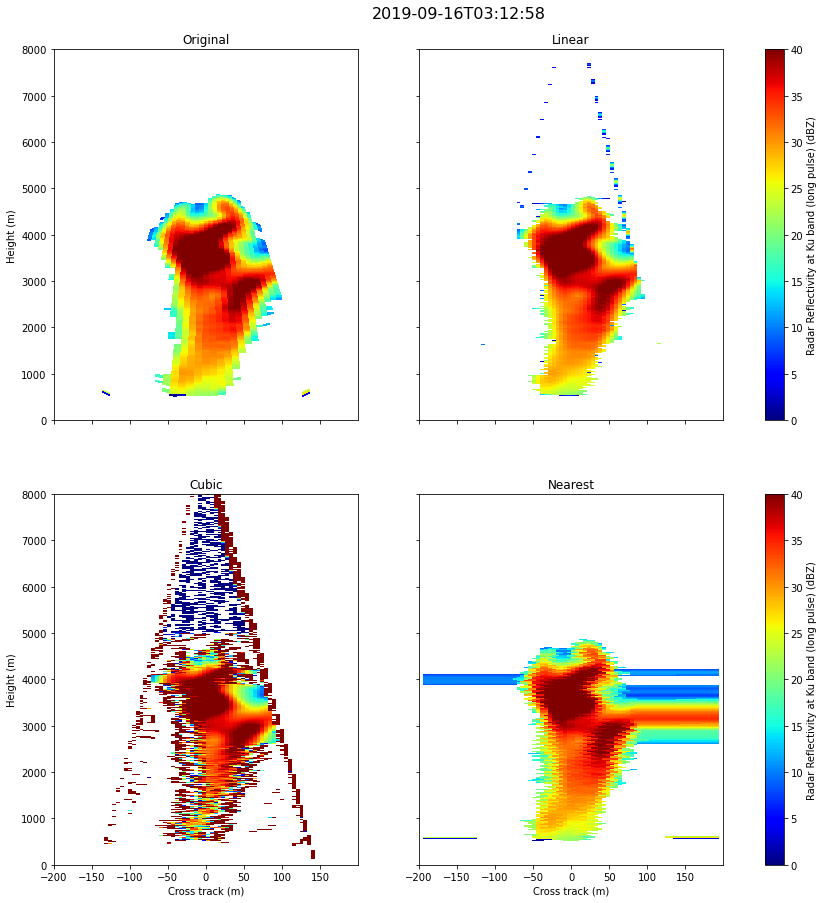

a


In [34]:
x, y, z0 = regrid(ds_xr)

In [36]:

def regrid(ds_xr):
 # ds_xr = ds_xr.where(ds_xr.alt3D > 500, drop=True)
    x = ds_xr.range * np.sin(np.deg2rad(ds_xr.azimuth))  # add roll
    y = ds_xr.alt3D * np.cos(np.deg2rad(ds_xr.azimuth))
    z = ds_xr.zhh14.where(ds_xr.alt3D > 500)
    # z = np.where(z > 0, z, 0)
    z = lee_filter_new(z, size=3, tresh=-180)
    z[z == -9999] = 0
    z[z == -180.] = 0
    x_s = x.values.flatten()
    y_s = y.values.flatten()
    z_s = z.compute().flatten()
    idx = x_s.argsort()
    x_s, y_s = np.take_along_axis(x_s, idx, axis=0), np.take_along_axis(y_s, idx, axis=0)
    z_s = np.take_along_axis(z_s, idx, axis=0)


    ### desired gridded data
    ncols = np.abs(x_s.max() - x_s.min()) / 5
    nrows = np.abs(y_s.max() - y_s.min()) / 5
    x_new = np.linspace(x_s.min(), x_s.max(), int(ncols))
    y_new = np.linspace(y_s.min(), y_s.max(), int(nrows))
    xi, yi = np.meshgrid(x_new, y_new)
    z0 = griddata((x_s, y_s), z_s, (xi, yi), method='linear', fill_value=0.0)
#     z0 = np.where(z0 > 0, z0, np.nan)
    z1 = griddata((x_s, y_s), z_s, (xi, yi), method='cubic', fill_value=0.0)
    z1 = np.where(z1 > 0, z1, np.nan)
    z2 = griddata((x_s, y_s), z_s, (xi, yi), method='nearest')
    z2 = np.where(z2 > 0, z2, np.nan)
    z = np.where(z > 0, z, np.nan)

    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    im = ax[0][0].pcolormesh(x, y, z, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[0][0].set_title('Original')

#     im = ax[0][1].pcolormesh(xi, yi, z0, cmap='jet', vmax=40, vmin=0, shading='auto')
    im = ax[0][1].imshow(z0, cmap='jet', vmax=40, vmin=0, aspect='auto', origin='lower')
    ax[0][1].set_title('Linear')

    im1 = ax[1][0].imshow(z1, cmap='jet', vmax=40, vmin=0, aspect='auto', origin='lower')
#     im1 = ax[1][0].pcolormesh(xi, yi, z1, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[1][0].set_title('Cubic')
    
    im2 = ax[1][1].imshow(z2, cmap='jet', vmax=40, vmin=0, aspect='auto', origin='lower')
#     im2 = ax[1][1].pcolormesh(xi, yi, z2, cmap='jet', vmax=40, vmin=0, shading='auto')
    ax[1][1].set_title('Nearest')

    cbar1 = plt.colorbar(im, ax=[ax[0][0], ax[0][1]])
    cbar1.set_label("\n".join(wrap(ds_xr.zhh14.notes, 50)) + ' (dBZ)')
    cbar2 = plt.colorbar(im2, ax=[ax[1][0], ax[1][1]])

    cbar2.set_label("\n".join(wrap(ds_xr.zhh14.notes, 50)) + ' (dBZ)')
    title = f"{np.datetime_as_string(ds_xr.time.values, unit='s')}\n"
    fig.suptitle(title, fontsize=16, y=.92)

#     ax[0][0].set_ylim(0, 8000)
#     ax[1][1].set_ylim(0, 8000)
    ax[1][0].set_ylabel('Height (m)')
    ax[1][0].set_xlabel('Cross track (m)')
    ax[0][0].set_ylabel('Height (m)')
    ax[1][1].set_xlabel('Cross track (m)')
#     plt.savefig('interpolation.jpg')
    plt.show()
    print('a')
    return xi, yi, z0


/tmp/ipykernel_181798/2929954065.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[0][0].pcolormesh(x, y, z, cmap='jet', vmax=40, vmin=0, shading='auto')


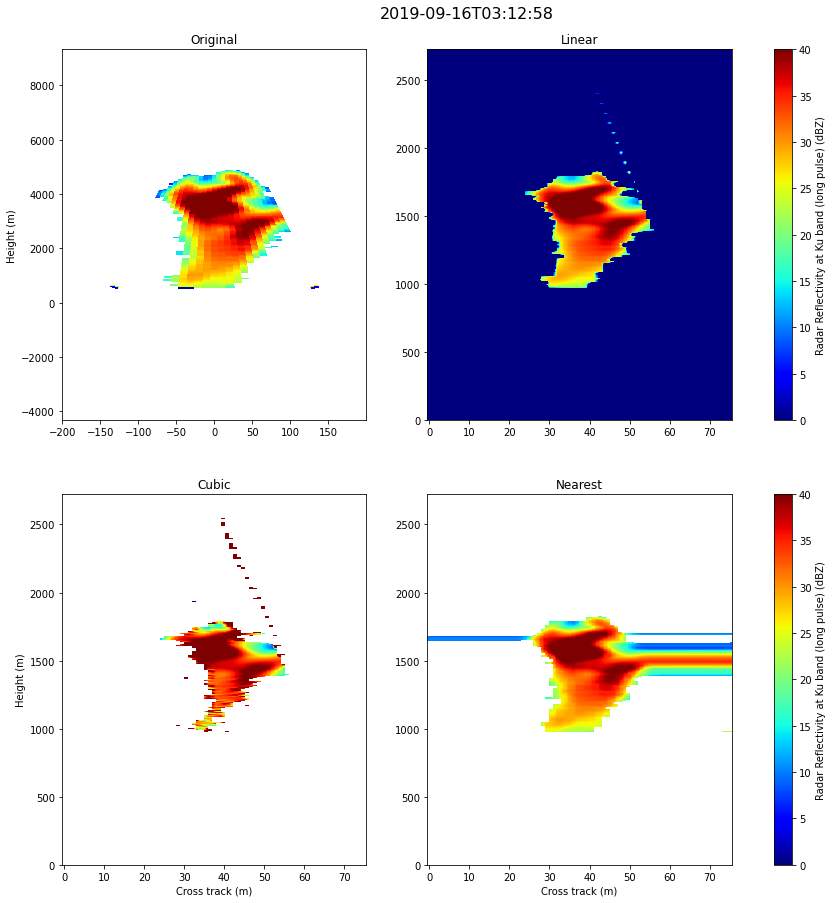

a


In [37]:
x, y, z0 = regrid(ds_xr)